# Loading Dataset and basic EDA

In [1]:
"""
Wheel of Time Text Processing Pipeline

This module provides a comprehensive system for processing the Wheel of Time book series
into a format suitable for semantic search and retrieval. The system handles EPUB files,
extracts meaningful chunks of text, and enriches them with metadata about their location
and context within the books.

The processing pipeline follows these steps:
1. Load EPUB files using UnstructuredEPubLoader
2. Split text into semantic chunks using custom separators
3. Extract and track chapter information
4. Enrich chunks with metadata (book name, chapter details)

The chunking strategy is specially designed for the Wheel of Time series, taking into
account its specific formatting patterns and narrative structure. The system recognizes
various chapter heading formats, scene breaks, and natural text boundaries to create
meaningful chunks that preserve context.

Author: Tharindu Sankalpa
Date: 2nd February 2025
"""

import os
import re
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from langchain_community.document_loaders import UnstructuredEPubLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

@dataclass
class ChapterInfo:
    """
    Holds information about a chapter in the Wheel of Time series.
    
    Attributes:
        number: The chapter number, which can be a digit or special marker like "PROLOGUE"
        title: The chapter's title
    """
    number: str
    title: str

class WheelOfTimeProcessor:
    """
    A comprehensive processor for the Wheel of Time book series that converts EPUB files
    into searchable text chunks with metadata.
    
    This class handles the entire pipeline of processing Wheel of Time books:
    - Loading EPUB files
    - Splitting text into meaningful chunks
    - Tracking chapter information
    - Enriching chunks with metadata
    
    The processor is specifically tuned for the Wheel of Time series' structure and
    formatting patterns, making it more accurate than general-purpose text processors.
    """

    def __init__(self, chunk_size: int = 1000, chunk_overlap: int = 200):
        """
        Initialize the Wheel of Time processor with customizable chunking parameters.

        The chunk size and overlap are crucial for creating meaningful text segments:
        - Larger chunks provide more context but may be too broad for precise retrieval
        - Smaller chunks are more precise but might miss broader context
        - Overlap helps maintain continuity between chunks

        Args:
            chunk_size: Target size of text chunks in characters. Default is 1000,
                       which typically captures 1-2 paragraphs of text.
            chunk_overlap: Number of characters to overlap between chunks. Default is 200,
                         which helps maintain context across chunk boundaries.
        """
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap

    def _create_text_splitter(self) -> RecursiveCharacterTextSplitter:
        """
        Create a specialized text splitter optimized for Wheel of Time books.

        The splitter uses a hierarchical set of separators that match the books'
        structure, from major divisions (chapters, prologues) down to sentence-level
        breaks. This ensures that chunks align with natural narrative boundaries.

        The separator patterns handle variations in formatting:
        1. Chapter markers (CHAPTER, Chapter, etc.)
        2. Scene breaks (typically marked with asterisks)
        3. Natural language breaks (sentence endings, dialogue)
        4. Fallback separators for consistent chunking

        Returns:
            A configured RecursiveCharacterTextSplitter ready to process WoT text
        """
        # Define section markers with case-insensitive matching
        section_patterns = [
            r'\nEPILOGUE\s*\n',
            r'\nepilogue\s*\n',
            r'\nEpilogue\s*\n',
            r'\nPROLOGUE\s*\n',
            r'\nprologue\s*\n',
            r'\nPrologue\s*\n',
            r'\nCHAPTER\s*\d*\s*\n',
            r'\nchapter\s*\d*\s*\n',
            r'\nChapter\s*\d*\s*\n',
        ]
        
        # Combine with general text separators
        wot_separators = (
            section_patterns +
            [
                "\n*   *   *\n",  # Scene breaks (asterisk pattern)
                "\n\n",           # Paragraph breaks
                ". ",             # Sentence endings
                "! ",            # Exclamation endings
                "? ",            # Question endings
                '"\n',           # Dialogue line breaks
                '" ',            # Dialogue
                "\n",            # Basic line breaks
                " ",             # Word breaks
                ""               # Character-level fallback
            ]
        )
        
        return RecursiveCharacterTextSplitter(
            separators=wot_separators,
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap
        )

    def _extract_chapter_info(self, text: str) -> ChapterInfo:
        """
        Extract chapter number and title from text using sophisticated pattern matching.

        This method handles the various ways chapters are formatted across the series,
        including:
        - Standard numbered chapters: "CHAPTER 8\nWhirlpools of Color"
        - Multi-line formats: "CHAPTER\n39\nThose Who Fight"
        - Special sections: "PROLOGUE\nDragonmount"
        - Variant capitalizations and spacing

        The method uses a series of regular expressions in decreasing order of
        specificity, trying to extract as much information as possible from the
        text.

        Args:
            text: The text to analyze for chapter information

        Returns:
            ChapterInfo object containing the chapter number and title
        """
        chapter_patterns = [
            # Standard format: "CHAPTER 8\nWhirlpools of Color"
            r'(?i)(?:CHAPTER|Chapter)\s*(\d+)\s*\n+([^\n]+)',
            
            # Split format: "CHAPTER\n39\nThose Who Fight"
            r'(?i)(?:CHAPTER|Chapter)\s*\n+(\d+)\s*\n+([^\n]+)',
            
            # Multi-newline format: "CHAPTER 8\n\nWhirlpools of Color"
            r'(?i)(?:CHAPTER|Chapter)\s*(\d+)\s*\n+\s*\n+([^\n]+)',
            
            # Written numbers: "CHAPTER EIGHT: The Title"
            r'(?i)(?:CHAPTER|Chapter)\s*([A-Za-z0-9]+):\s*([^\n]+)',
            
            # Simple title: "CHAPTER: The Title"
            r'(?i)(?:CHAPTER|Chapter):\s*([^\n]+)',
            
            # Special sections: "PROLOGUE\nThe Title"
            r'(?i)(?:PROLOGUE|Prologue|EPILOGUE|Epilogue)\s*\n+([^\n]+)',
            
            # Bare chapters: "CHAPTER 8" or "PROLOGUE"
            r'(?i)(?:CHAPTER|Chapter)\s*(\d+)\s*$',
            r'(?i)(?:PROLOGUE|Prologue|EPILOGUE|Epilogue)\s*$'
        ]
        
        for pattern in chapter_patterns:
            match = re.search(pattern, text)
            if match:
                groups = match.groups()
                if len(groups) == 2:
                    return ChapterInfo(
                        number=groups[0],
                        title=groups[1].strip()
                    )
                elif len(groups) == 1:
                    return ChapterInfo(
                        number="N/A",
                        title=groups[0].strip()
                    )
        
        return ChapterInfo(number="N/A", title="N/A")

    def process_epub(self, epub_path: str) -> List[Document]:
        """
        Process a single Wheel of Time EPUB file into enriched text chunks.

        This method performs the complete processing pipeline for a single book:
        1. Loads the EPUB file
        2. Extracts the book name
        3. Splits the text into chunks
        4. Tracks chapter information across chunks
        5. Enriches chunks with metadata

        The method maintains chapter context across chunk boundaries, ensuring that
        each chunk knows which chapter it belongs to, even if it doesn't contain
        a chapter heading itself.

        Args:
            epub_path: Path to the EPUB file to process

        Returns:
            List of Document objects, each containing a text chunk and its metadata

        Example:
            processor = WheelOfTimeProcessor()
            chunks = processor.process_epub("eye_of_the_world.epub")
        """
        # Load the EPUB
        loader = UnstructuredEPubLoader(epub_path)
        data = loader.load()
        
        # Extract book name from path
        book_name = os.path.basename(epub_path).replace('.epub', '')
        
        # Create text splitter and split document
        text_splitter = self._create_text_splitter()
        chunks = text_splitter.split_documents(data)
        
        # Initialize chapter tracking
        current_chapter = ChapterInfo(number="N/A", title="N/A")
        
        # Process each chunk
        for chunk in chunks:
            # Check for new chapter information
            chapter_info = self._extract_chapter_info(chunk.page_content)
            if chapter_info.number != "N/A" or chapter_info.title != "N/A":
                current_chapter = chapter_info
            
            # Enrich chunk with metadata
            chunk.metadata.update({
                "book_name": book_name,
                "chapter_number": current_chapter.number,
                "chapter_title": current_chapter.title
            })
        
        return chunks

    def process_series(self, epub_dir: str) -> List[Document]:
        """
        Process the entire Wheel of Time series from a directory of EPUB files.

        This method processes all EPUB files in the specified directory, combining
        them into a single collection of chunks while maintaining proper book and
        chapter context for each chunk.

        Args:
            epub_dir: Directory containing Wheel of Time EPUB files

        Returns:
            List of all processed chunks across the entire series

        Example:
            processor = WheelOfTimeProcessor()
            chunks = processor.process_series("wheel_of_time_epubs/")
            print(f"Processed {len(chunks)} chunks across the series")
        """
        all_chunks = []
        
        for filename in sorted(os.listdir(epub_dir)):
            if filename.endswith('.epub'):
                epub_path = os.path.join(epub_dir, filename)
                try:
                    chunks = self.process_epub(epub_path)
                    all_chunks.extend(chunks)
                    print(f"Processed {filename}: {len(chunks)} chunks created")
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
        
        return all_chunks

In [2]:
processor = WheelOfTimeProcessor(chunk_size=400, chunk_overlap=100)

# Process the entire series
epub_dir = "../data"
chunks = processor.process_series(epub_dir)
    
print(f"Total chunks processed: {len(chunks)}")

Processed 00. New Spring.epub: 2557 chunks created
Processed 01. The Eye of the World.epub: 6367 chunks created
Processed 02. The Great Hunt.epub: 5489 chunks created
Processed 03. The Dragon Reborn.epub: 5137 chunks created
Processed 04. The Shadow Rising.epub: 8088 chunks created
Processed 05. The Fires of Heaven.epub: 7285 chunks created
Processed 06. Lord of Chaos.epub: 8378 chunks created
Processed 07. A Crown of Swords.epub: 6208 chunks created
Processed 08. The Path of Daggers.epub: 4762 chunks created
Processed 09. Winter_s Heart.epub: 5037 chunks created
Processed 10. Crossroads of Twilight.epub: 5616 chunks created
Processed 11. Knife of Dreams.epub: 6724 chunks created
Processed 12. The Gathering Storm.epub: 6357 chunks created
Processed 13. Towers of Midnight.epub: 6749 chunks created
Processed 14. A Memory of Light.epub: 7177 chunks created
Processed The Wheel of Time Companion _ The People, Places and History of the Bestselling Series.epub: 8174 chunks created
Total chunk

# Dataset Analysis - Convert to DataFrame and Analyze Character Counts

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert LangChain Document objects to DataFrame
print("Converting chunks to DataFrame...")

# Extract data from Document objects
data = []
for chunk in chunks:
    data.append({
        'text': chunk.page_content,
        'book_name': chunk.metadata.get('book_name', 'N/A'),
        'chapter_number': chunk.metadata.get('chapter_number', 'N/A'),
        'chapter_title': chunk.metadata.get('chapter_title', 'N/A'),
        'char_count': len(chunk.page_content)
    })

# Create DataFrame
df = pd.DataFrame(data)

print(f"\nDataFrame created with {len(df):,} rows")
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Converting chunks to DataFrame...

DataFrame created with 100,105 rows

DataFrame shape: (100105, 5)

Column names: ['text', 'book_name', 'chapter_number', 'chapter_title', 'char_count']

Memory usage: 74.07 MB


In [4]:
df

,text,book_name,chapter_number,chapter_title,char_count
0,image,00. New Spring,N/A,N/A,5
1,The author and publisher have provided this e-...,00. New Spring,N/A,N/A,305
2,". You may not print or post this e-book, or ma...",00. New Spring,N/A,N/A,197
3,Copyright infringement is against the law. If ...,00. New Spring,N/A,N/A,393
4,5 The Human Heart\n\n6 Surprises\n\n7 The Itch...,00. New Spring,N/A,N/A,389
...,...,...,...,...,...
100100,The Fallon Blood\n\nThe Fallon Pride\n\nThe Fa...,"The Wheel of Time Companion _ The People, Plac...",N/A,N/A,390
100101,sign up for our newsletters.\n\nimage\n\nOr vi...,"The Wheel of Time Companion _ The People, Plac...",N/A,N/A,396
100102,THE WHEEL OF TIME COMPANION\n\nCopyright © 201...,"The Wheel of Time Companion _ The People, Plac...",N/A,N/A,377
100103,The Library of Congress Cataloging-in-Publicat...,"The Wheel of Time Companion _ The People, Plac...",N/A,N/A,172


## Character Count Statistics

In [5]:
# Overall character count statistics
print("Character Count Statistics")
print("=" * 60)
print(f"Mean:       {df['char_count'].mean():.2f} characters")
print(f"Median:     {df['char_count'].median():.2f} characters")
print(f"Std Dev:    {df['char_count'].std():.2f} characters")
print(f"Min:        {df['char_count'].min()} characters")
print(f"Max:        {df['char_count'].max()} characters")
print(f"\nPercentiles:")
print(f"  25th:     {df['char_count'].quantile(0.25):.2f} characters")
print(f"  50th:     {df['char_count'].quantile(0.50):.2f} characters")
print(f"  75th:     {df['char_count'].quantile(0.75):.2f} characters")
print(f"  90th:     {df['char_count'].quantile(0.90):.2f} characters")
print(f"  95th:     {df['char_count'].quantile(0.95):.2f} characters")
print(f"  99th:     {df['char_count'].quantile(0.99):.2f} characters")

# Distribution bins
print(f"\nCharacter Count Distribution:")
bins = [0, 20, 40, 60, 80, 100, 150, 200, 500, 1000, float('inf')]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100', '100-150', '150-200', '200-500', '500-1000', '1000+']
df['char_range'] = pd.cut(df['char_count'], bins=bins, labels=labels)
print(df['char_range'].value_counts().sort_index())

Character Count Statistics
Mean:       283.63 characters
Median:     305.00 characters
Std Dev:    89.43 characters
Min:        4 characters
Max:        400 characters

Percentiles:
  25th:     225.00 characters
  50th:     305.00 characters
  75th:     358.00 characters
  90th:     383.00 characters
  95th:     391.00 characters
  99th:     398.00 characters

Character Count Distribution:
char_range
0-20           90
20-40         473
40-60         845
60-80        1132
80-100       1648
100-150      6408
150-200      9027
200-500     80482
500-1000        0
1000+           0
Name: count, dtype: int64


## Analysis by Book

In [6]:
# Chunks per book
print("Chunks per Book")
print("=" * 80)
book_stats = df.groupby('book_name').agg({
    'text': 'count',
    'char_count': ['mean', 'median', 'sum']
}).round(2)
book_stats.columns = ['chunk_count', 'avg_chars', 'median_chars', 'total_chars']
book_stats = book_stats.sort_index()
print(book_stats.to_string())

print(f"\n\nTotal characters across all books: {df['char_count'].sum():,}")
print(f"Total chunks across all books: {len(df):,}")

Chunks per Book
                                                                                        chunk_count  avg_chars  median_chars  total_chars
book_name                                                                                                                                
00. New Spring                                                                                 2557     282.87         306.0       723296
01. The Eye of the World                                                                       6367     280.82         304.0      1787999
02. The Great Hunt                                                                             5489     279.00         303.0      1531441
03. The Dragon Reborn                                                                          5137     277.94         299.0      1427790
04. The Shadow Rising                                                                          8088     280.35         303.0      2267437
05. The Fires of H

## Visualizations

/var/folders/_j/56hv4rgj2yn_2z_m3dwvcwhc0000gn/T/ipykernel_20126/3937040669.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(data_to_plot, labels=[b.split('.')[0] for b in books])


Visualization saved to ../data/wot_chunks_analysis.png


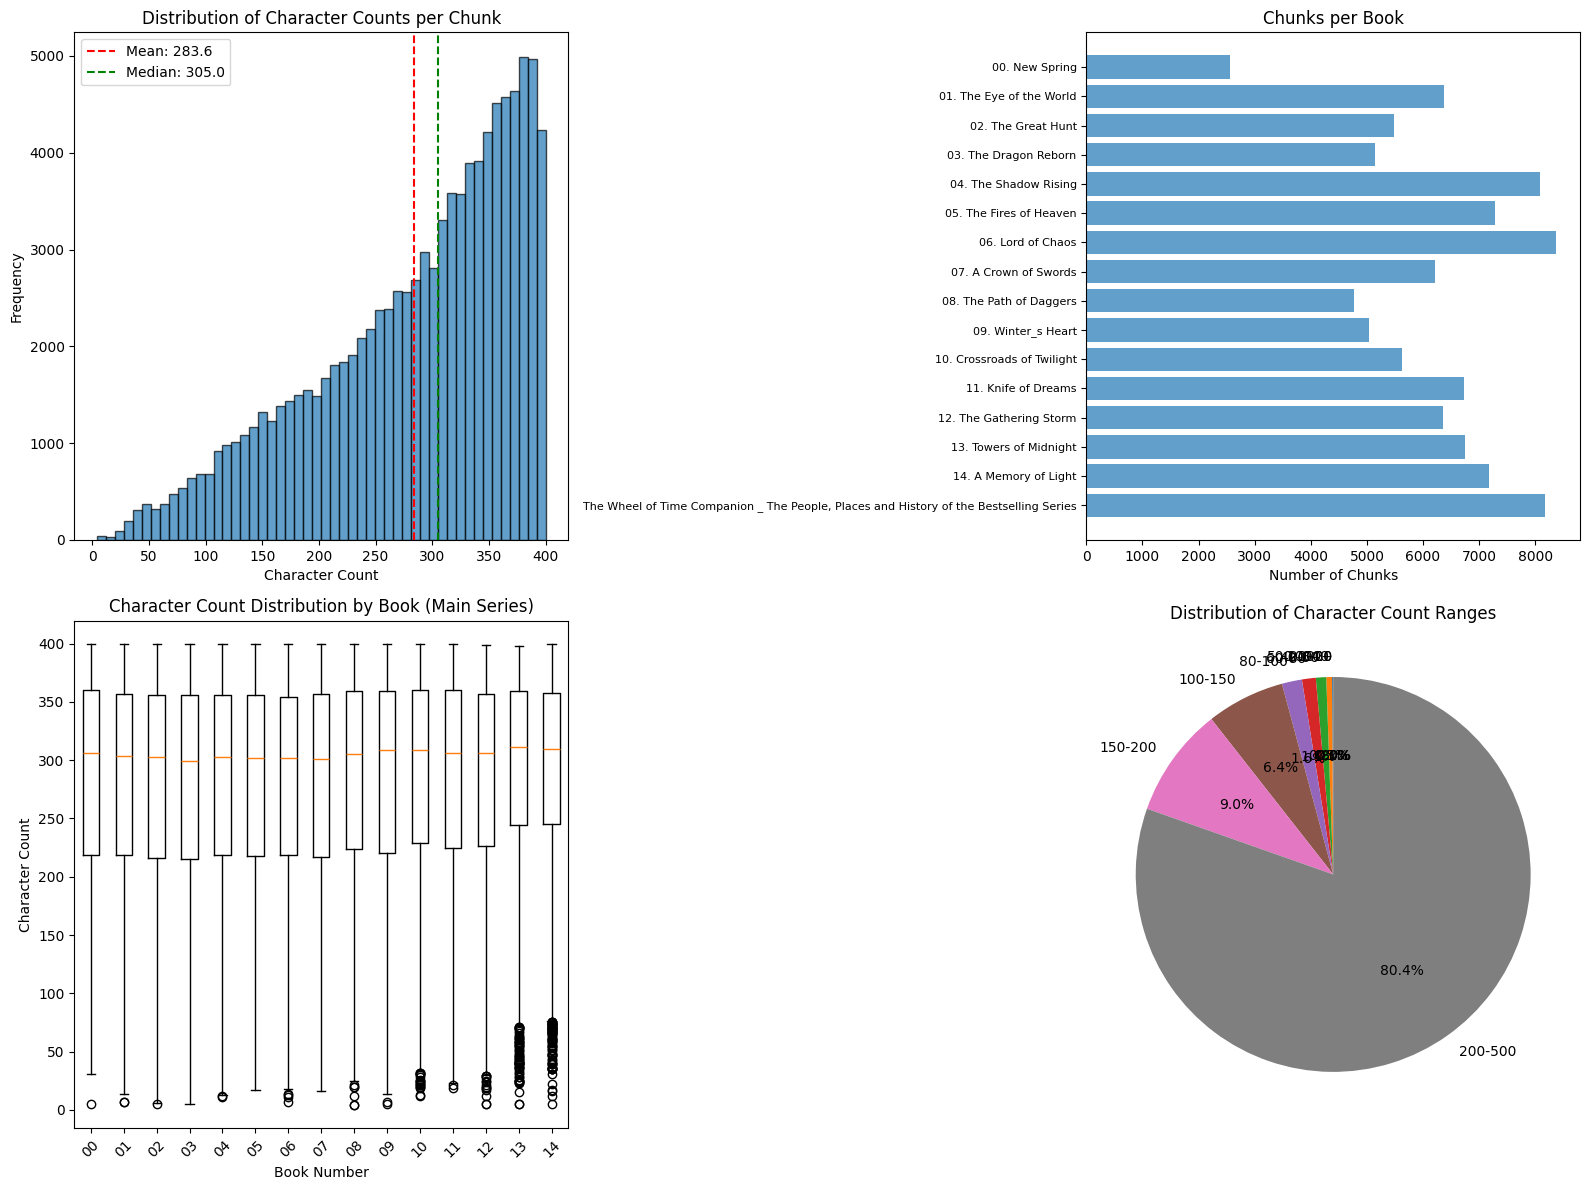

In [7]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Character count distribution (histogram)
axes[0, 0].hist(df['char_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Character Counts per Chunk')
axes[0, 0].axvline(df['char_count'].mean(), color='red', linestyle='--', label=f"Mean: {df['char_count'].mean():.1f}")
axes[0, 0].axvline(df['char_count'].median(), color='green', linestyle='--', label=f"Median: {df['char_count'].median():.1f}")
axes[0, 0].legend()

# 2. Chunks per book (bar chart)
book_counts = df['book_name'].value_counts().sort_index()
axes[0, 1].barh(range(len(book_counts)), book_counts.values, alpha=0.7)
axes[0, 1].set_yticks(range(len(book_counts)))
axes[0, 1].set_yticklabels(book_counts.index, fontsize=8)
axes[0, 1].set_xlabel('Number of Chunks')
axes[0, 1].set_title('Chunks per Book')
axes[0, 1].invert_yaxis()

# 3. Character count by book (box plot)
df_plot = df[df['book_name'].str.contains('^\d{2}\.', regex=True)]  # Filter main series books
books = sorted(df_plot['book_name'].unique())
data_to_plot = [df_plot[df_plot['book_name'] == book]['char_count'].values for book in books]
axes[1, 0].boxplot(data_to_plot, labels=[b.split('.')[0] for b in books])
axes[1, 0].set_xlabel('Book Number')
axes[1, 0].set_ylabel('Character Count')
axes[1, 0].set_title('Character Count Distribution by Book (Main Series)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Character range distribution (pie chart)
char_range_counts = df['char_range'].value_counts().sort_index()
axes[1, 1].pie(char_range_counts.values, labels=char_range_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Distribution of Character Count Ranges')

plt.tight_layout()
plt.savefig('../data/wot_chunks_analysis.png', dpi=300, bbox_inches='tight')
print("Visualization saved to ../data/wot_chunks_analysis.png")
plt.show()

## Save Dataset to Data Directory

In [8]:
# Remove the char_range column before saving (temporary analysis column)
df_save = df.drop('char_range', axis=1)

# Save as CSV (for easy inspection)
csv_path = '../data/wot_chunks.csv'
print(f"Saving to CSV: {csv_path}")
df_save.to_csv(csv_path, index=False)
csv_size = os.path.getsize(csv_path) / 1024**2
print(f"  CSV file size: {csv_size:.2f} MB")

# Save as Parquet (for efficient storage and loading)
parquet_path = '../data/wot_chunks.parquet'
print(f"\nSaving to Parquet: {parquet_path}")
df_save.to_parquet(parquet_path, index=False, compression='snappy')
parquet_size = os.path.getsize(parquet_path) / 1024**2
print(f"  Parquet file size: {parquet_size:.2f} MB")
print(f"  Compression ratio: {csv_size/parquet_size:.2f}x")

print(f"\n{'='*60}")
print(f"Dataset saved successfully!")
print(f"  Total records: {len(df_save):,}")
print(f"  Total columns: {len(df_save.columns)}")
print(f"  Columns: {list(df_save.columns)}")
print(f"{'='*60}")

Saving to CSV: ../data/wot_chunks.csv
  CSV file size: 31.89 MB

Saving to Parquet: ../data/wot_chunks.parquet
  Parquet file size: 16.26 MB
  Compression ratio: 1.96x

Dataset saved successfully!
  Total records: 100,105
  Total columns: 5
  Columns: ['text', 'book_name', 'chapter_number', 'chapter_title', 'char_count']


## Sample Data Preview

In [9]:
# Display first few rows
print("First 5 rows of the dataset:")
print("="*80)
print(df_save.head())

print("\n\nSample text from first chunk:")
print("="*80)
print(df_save.iloc[0]['text'])

print("\n\nDataset Info:")
print("="*80)
df_save.info()

First 5 rows of the dataset:
                                                text       book_name  \
0                                              image  00. New Spring   
1  The author and publisher have provided this e-...  00. New Spring   
2  . You may not print or post this e-book, or ma...  00. New Spring   
3  Copyright infringement is against the law. If ...  00. New Spring   
4  5 The Human Heart\n\n6 Surprises\n\n7 The Itch...  00. New Spring   

  chapter_number chapter_title  char_count  
0            N/A           N/A           5  
1            N/A           N/A         305  
2            N/A           N/A         197  
3            N/A           N/A         393  
4            N/A           N/A         389  


Sample text from first chunk:
image


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100105 entries, 0 to 100104
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text     

Based on the context of aircraft maintenance logs, "NIL" is a very common abbreviation. It almost certainly means "Nothing" or "No Fault Found".

# Cost and Time Analysis for Embedding Generation

Before generating embeddings, let's calculate the exact cost and time requirements based on:
- Azure OpenAI Deployment: text-embedding-ada-002
- TPS (Tokens Per Second): 66,000
- RPS (Requests Per Second): 396
- Pricing: $0.0001 per 1K tokens

In [10]:
import tiktoken

# Initialize tokenizer for Azure OpenAI embeddings (cl100k_base is used by text-embedding-ada-002)
encoding = tiktoken.get_encoding("cl100k_base")

# Sample chunks to estimate average token count
print("Estimating token counts from sample data...")
sample_size = min(10000, len(df_save))
sample_texts = df_save['text'].head(sample_size).tolist()

# Calculate tokens for sample
token_counts = [len(encoding.encode(text)) for text in sample_texts]
avg_tokens_per_chunk = sum(token_counts) / len(token_counts)
max_tokens_in_sample = max(token_counts)
min_tokens_in_sample = min(token_counts)

print(f"\nToken Analysis (based on {sample_size:,} samples):")
print(f"  Average tokens per chunk: {avg_tokens_per_chunk:.2f}")
print(f"  Min tokens in sample: {min_tokens_in_sample}")
print(f"  Max tokens in sample: {max_tokens_in_sample}")
print(f"  Median tokens: {sorted(token_counts)[len(token_counts)//2]}")

# Total dataset stats
total_chunks = len(df_save)
estimated_total_tokens = total_chunks * avg_tokens_per_chunk

print(f"\nTotal Dataset Estimation:")
print(f"  Total chunks: {total_chunks:,}")
print(f"  Estimated total tokens: {estimated_total_tokens:,.0f}")
print(f"  Estimated total tokens (in millions): {estimated_total_tokens/1_000_000:.2f}M")

Estimating token counts from sample data...

Token Analysis (based on 10,000 samples):
  Average tokens per chunk: 67.33
  Min tokens in sample: 1
  Max tokens in sample: 121
  Median tokens: 72

Total Dataset Estimation:
  Total chunks: 100,105
  Estimated total tokens: 6,739,899
  Estimated total tokens (in millions): 6.74M


## Cost Analysis

In [11]:
# Azure OpenAI Pricing for text-embedding-ada-002
# Source: https://azure.microsoft.com/en-us/pricing/details/cognitive-services/openai-service/
PRICE_PER_1K_TOKENS = 0.0001  # USD

# Calculate total cost
total_cost_usd = (estimated_total_tokens / 1000) * PRICE_PER_1K_TOKENS

print("Cost Analysis")
print("=" * 60)
print(f"Pricing model: text-embedding-ada-002")
print(f"Rate: ${PRICE_PER_1K_TOKENS} per 1K tokens")
print(f"\nEstimated total tokens: {estimated_total_tokens:,.0f}")
print(f"Estimated total cost: ${total_cost_usd:.2f} USD")
print("=" * 60)

# Cost breakdown for different dataset sizes
print("\n\nCost Breakdown for Different Dataset Sizes:")
print("-" * 60)
for percentage in [10, 25, 50, 75, 100]:
    subset_chunks = int(total_chunks * percentage / 100)
    subset_tokens = estimated_total_tokens * percentage / 100
    subset_cost = (subset_tokens / 1000) * PRICE_PER_1K_TOKENS
    print(f"{percentage:3d}% ({subset_chunks:8,} chunks): ${subset_cost:7.2f} USD | {subset_tokens/1_000_000:5.2f}M tokens")

print("\n\nRecommendations:")
print("-" * 60)
print("• For initial testing: Use 10-25% of dataset")
print("• For benchmarking: Use 25-50% of dataset") 
print("• For production: Use 100% of dataset")
print(f"\n• Budget required for full dataset: ~${total_cost_usd:.2f} USD")

Cost Analysis
Pricing model: text-embedding-ada-002
Rate: $0.0001 per 1K tokens

Estimated total tokens: 6,739,899
Estimated total cost: $0.67 USD


Cost Breakdown for Different Dataset Sizes:
------------------------------------------------------------
 10% (  10,010 chunks): $   0.07 USD |  0.67M tokens
 25% (  25,026 chunks): $   0.17 USD |  1.68M tokens
 50% (  50,052 chunks): $   0.34 USD |  3.37M tokens
 75% (  75,078 chunks): $   0.51 USD |  5.05M tokens
100% ( 100,105 chunks): $   0.67 USD |  6.74M tokens


Recommendations:
------------------------------------------------------------
• For initial testing: Use 10-25% of dataset
• For benchmarking: Use 25-50% of dataset
• For production: Use 100% of dataset

• Budget required for full dataset: ~$0.67 USD


## Time Analysis Based on Azure OpenAI Deployment Limits

In [12]:
# Azure OpenAI Deployment Limits
TPS_LIMIT = 66_000  # Tokens Per Second
RPS_LIMIT = 396     # Requests Per Second

print("Azure OpenAI Deployment Limits")
print("=" * 60)
print(f"TPS (Tokens Per Second): {TPS_LIMIT:,}")
print(f"RPS (Requests Per Second): {RPS_LIMIT:,}")
print("=" * 60)

# Batch size optimization
RECOMMENDED_BATCH_SIZE = 1000  # Balance between efficiency and safety
print(f"\nBatch Size: {RECOMMENDED_BATCH_SIZE}")
print(f"  (Azure max: 2048, using {RECOMMENDED_BATCH_SIZE} for safety)")

# Calculate time based on different constraints
print("\n\nTime Analysis:")
print("-" * 60)

# Scenario 1: Limited by TPS (Token throughput)
time_limited_by_tps_seconds = estimated_total_tokens / TPS_LIMIT
time_limited_by_tps_hours = time_limited_by_tps_seconds / 3600
time_limited_by_tps_minutes = time_limited_by_tps_seconds / 60

print(f"\n1. If limited by TPS ({TPS_LIMIT:,} tokens/sec):")
print(f"   Time required: {time_limited_by_tps_seconds:,.0f} seconds")
print(f"                  {time_limited_by_tps_minutes:,.1f} minutes")
print(f"                  {time_limited_by_tps_hours:.2f} hours")

# Scenario 2: Limited by RPS with optimized batch size
total_batches_optimized = (total_chunks + RECOMMENDED_BATCH_SIZE - 1) // RECOMMENDED_BATCH_SIZE
time_limited_by_rps_seconds = total_batches_optimized / RPS_LIMIT
time_limited_by_rps_hours = time_limited_by_rps_seconds / 3600
time_limited_by_rps_minutes = time_limited_by_rps_seconds / 60

print(f"\n2. If limited by RPS ({RPS_LIMIT:,} requests/sec) with batch_size={RECOMMENDED_BATCH_SIZE}:")
print(f"   Total batches needed: {total_batches_optimized:,}")
print(f"   Time required: {time_limited_by_rps_seconds:,.0f} seconds")
print(f"                  {time_limited_by_rps_minutes:,.1f} minutes")
print(f"                  {time_limited_by_rps_hours:.2f} hours")

# Determine the actual bottleneck
bottleneck = "TPS (token throughput)" if time_limited_by_tps_seconds > time_limited_by_rps_seconds else "RPS (request rate)"
actual_time_seconds = max(time_limited_by_tps_seconds, time_limited_by_rps_seconds)
actual_time_hours = actual_time_seconds / 3600
actual_time_minutes = actual_time_seconds / 60

print(f"\n3. ACTUAL TIME (limited by {bottleneck}):")
print(f"   Theoretical minimum: {actual_time_seconds:,.0f} seconds")
print(f"                        {actual_time_minutes:,.1f} minutes") 
print(f"                        {actual_time_hours:.2f} hours")

# Account for minimal overhead with optimized approach
# Using 90% of RPS limit = 1/(396*0.9) = 0.0028s per request
min_time_between_requests = 1.0 / (RPS_LIMIT * 0.9)
overhead_seconds = total_batches_optimized * min_time_between_requests
overhead_hours = overhead_seconds / 3600

realistic_time_seconds = actual_time_seconds + overhead_seconds
realistic_time_hours = realistic_time_seconds / 3600

print(f"\n4. REALISTIC TIME (optimized with batch_size={RECOMMENDED_BATCH_SIZE}):")
print(f"   Total batches: {total_batches_optimized:,}")
print(f"   Min time between requests: {min_time_between_requests:.4f}s (90% of RPS limit)")
print(f"   Overhead time: {overhead_seconds:,.0f} seconds ({overhead_hours:.2f} hours)")
print(f"   ")
print(f"   Total realistic time: {realistic_time_seconds:,.0f} seconds")
print(f"                         {realistic_time_seconds/60:,.1f} minutes")
print(f"                         {realistic_time_hours:.2f} hours")

# Comparison with old approach
old_batch_size = 100
old_sleep_time = 0.5
old_total_batches = (total_chunks + old_batch_size - 1) // old_batch_size
old_sleep_overhead = old_total_batches * old_sleep_time
old_total_time_hours = (actual_time_seconds + old_sleep_overhead) / 3600

print(f"\n5. COMPARISON - Old vs Optimized Approach:")
print(f"   Old (batch_size=100, sleep=0.5s):")
print(f"     Total time: {old_total_time_hours:.2f} hours")
print(f"   Optimized (batch_size={RECOMMENDED_BATCH_SIZE}, minimal sleep):")
print(f"     Total time: {realistic_time_hours:.2f} hours")
print(f"   ")
print(f"   SPEEDUP: {old_total_time_hours/realistic_time_hours:.1f}x faster!")
print(f"   TIME SAVED: {(old_total_time_hours - realistic_time_hours):.2f} hours")

print("\n" + "=" * 60)

Azure OpenAI Deployment Limits
TPS (Tokens Per Second): 66,000
RPS (Requests Per Second): 396

Batch Size: 1000
  (Azure max: 2048, using 1000 for safety)


Time Analysis:
------------------------------------------------------------

1. If limited by TPS (66,000 tokens/sec):
   Time required: 102 seconds
                  1.7 minutes
                  0.03 hours

2. If limited by RPS (396 requests/sec) with batch_size=1000:
   Total batches needed: 101
   Time required: 0 seconds
                  0.0 minutes
                  0.00 hours

3. ACTUAL TIME (limited by TPS (token throughput)):
   Theoretical minimum: 102 seconds
                        1.7 minutes
                        0.03 hours

4. REALISTIC TIME (optimized with batch_size=1000):
   Total batches: 101
   Min time between requests: 0.0028s (90% of RPS limit)
   Overhead time: 0 seconds (0.00 hours)
   
   Total realistic time: 102 seconds
                         1.7 minutes
                         0.03 hours

5. COMPA

## Summary and Recommendations

In [13]:
import datetime

print("=" * 80)
print(" " * 20 + "EMBEDDING GENERATION SUMMARY")
print("=" * 80)

print(f"\nDataset:")
print(f"  Total chunks: {total_chunks:,}")
print(f"  Estimated tokens: {estimated_total_tokens:,.0f} ({estimated_total_tokens/1_000_000:.2f}M)")
print(f"  Avg tokens/chunk: {avg_tokens_per_chunk:.2f}")

print(f"\nAzure OpenAI Deployment:")
print(f"  Model: text-embedding-ada-002")
print(f"  TPS Limit: {TPS_LIMIT:,}")
print(f"  RPS Limit: {RPS_LIMIT:,}")
print(f"  Bottleneck: {bottleneck}")

print(f"\nCost Estimate:")
print(f"  Total cost: ${total_cost_usd:.2f} USD")
print(f"  Cost per chunk: ${total_cost_usd/total_chunks:.6f} USD")

print(f"\nTime Estimate:")
print(f"  Theoretical minimum: {actual_time_hours:.2f} hours")
print(f"  Realistic (with overhead): {realistic_time_hours:.2f} hours")
print(f"  Expected completion: ~{realistic_time_hours:.1f} hours ({realistic_time_hours/24:.2f} days)")

# Calculate expected end time if starting now
if realistic_time_hours < 24:
    end_time = datetime.datetime.now() + datetime.timedelta(hours=realistic_time_hours)
    print(f"  If started now: Complete by {end_time.strftime('%Y-%m-%d %I:%M %p')}")

print("\n" + "=" * 80)
print("RECOMMENDED APPROACH FOR BENCHMARKING")
print("=" * 80)

# Calculate subset recommendations
for name, percentage in [("Quick Test", 10), ("Standard Benchmark", 25), ("Large Benchmark", 50), ("Full Dataset", 100)]:
    subset_chunks = int(total_chunks * percentage / 100)
    subset_tokens = estimated_total_tokens * percentage / 100
    subset_cost = (subset_tokens / 1000) * PRICE_PER_1K_TOKENS
    subset_time = (realistic_time_hours * percentage / 100)
    
    print(f"\n{name} ({percentage}%):")
    print(f"  Chunks: {subset_chunks:,}")
    print(f"  Cost: ${subset_cost:.2f} USD")
    print(f"  Time: {subset_time:.2f} hours")
    
    if percentage == 10:
        print(f"  → Use for: Initial setup validation")
    elif percentage == 25:
        print(f"  → Use for: Primary benchmarking comparison")
    elif percentage == 50:
        print(f"  → Use for: Extended performance testing")
    else:
        print(f"  → Use for: Production deployment")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print("""
1. Choose dataset size based on budget and time constraints
2. For benchmarking, 25% (250K-300K chunks) is recommended:
   - Large enough for meaningful performance metrics
   - Manageable cost and time
   - Sufficient for database comparison
   
3. Update the embedding generation code with chosen parameters
4. Run embedding generation (consider overnight/weekend run)
5. Proceed with benchmarking across:
   - Milvus Zilliz Cloud
   - Milvus Self-Hosted (GKE)
   - MongoDB Atlas Search
""")

                    EMBEDDING GENERATION SUMMARY

Dataset:
  Total chunks: 100,105
  Estimated tokens: 6,739,899 (6.74M)
  Avg tokens/chunk: 67.33

Azure OpenAI Deployment:
  Model: text-embedding-ada-002
  TPS Limit: 66,000
  RPS Limit: 396
  Bottleneck: TPS (token throughput)

Cost Estimate:
  Total cost: $0.67 USD
  Cost per chunk: $0.000007 USD

Time Estimate:
  Theoretical minimum: 0.03 hours
  Realistic (with overhead): 0.03 hours
  Expected completion: ~0.0 hours (0.00 days)
  If started now: Complete by 2025-11-08 04:36 PM

RECOMMENDED APPROACH FOR BENCHMARKING

Quick Test (10%):
  Chunks: 10,010
  Cost: $0.07 USD
  Time: 0.00 hours
  → Use for: Initial setup validation

Standard Benchmark (25%):
  Chunks: 25,026
  Cost: $0.17 USD
  Time: 0.01 hours
  → Use for: Primary benchmarking comparison

Large Benchmark (50%):
  Chunks: 50,052
  Cost: $0.34 USD
  Time: 0.01 hours
  → Use for: Extended performance testing

Full Dataset (100%):
  Chunks: 100,105
  Cost: $0.67 USD
  Time: 0

# Generate Embeddings (Configurable Subset)

In [16]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
import time
from tqdm.auto import tqdm

# Load Azure OpenAI credentials from .env.azure file
load_dotenv('../.env.azure')

# Initialize Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION", "2024-02-01"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT")
)

# Configuration
DEPLOYMENT_NAME = os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT", "text-embedding-ada-002")
EMBEDDING_DIMENSIONS = int(os.getenv("AZURE_OPENAI_EMBEDDING_DIMENSIONS", "1536"))

# ========================================================================
# CONFIGURATION: Set the percentage of data to embed
# ========================================================================
EMBED_PERCENTAGE = 100  # Options: 10, 25, 50, 100
BATCH_SIZE = 100      # Max 2048 for Azure, using 1000 for safety
# ========================================================================

subset_size = int(len(df_save) * EMBED_PERCENTAGE / 100)
print(f"Embedding Configuration:")
print(f"  Percentage: {EMBED_PERCENTAGE}%")
print(f"  Subset size: {subset_size:,} chunks")
print(f"  Total dataset: {len(df_save):,} chunks")
print(f"  Batch size: {BATCH_SIZE}")

def generate_embeddings_batch_optimized(texts, batch_size=100, checkpoint_interval=1000, 
                                        checkpoint_file='../data/wot_embeddings_checkpoint.parquet',
                                        rps_limit=396, tps_limit=66000):
    """
    Optimized embedding generation with intelligent rate limiting
    
    Args:
        texts: List of text strings to embed
        batch_size: Number of texts per API call (max 2048 for Azure, recommended 1000-2000)
        checkpoint_interval: Save progress every N embeddings
        checkpoint_file: Path to checkpoint file for resumability
        rps_limit: Requests per second limit
        tps_limit: Tokens per second limit
    """
    embeddings = []
    start_index = 0
    
    # Check for existing checkpoint
    if os.path.exists(checkpoint_file):
        print(f"\nFound checkpoint file. Loading existing embeddings...")
        checkpoint_df = pd.read_parquet(checkpoint_file)
        embeddings = checkpoint_df['embedding'].tolist()
        start_index = len(embeddings)
        print(f"  Resuming from index {start_index:,}")
    
    # Calculate optimal sleep time based on RPS limit
    # Use 90% of limit to stay safe but efficient
    min_time_between_requests = 1.0 / (rps_limit * 0.9) if rps_limit > 0 else 0.0
    
    total_batches = (len(texts) - start_index + batch_size - 1) // batch_size
    
    print(f"\nProcessing Configuration:")
    print(f"  Texts to process: {len(texts) - start_index:,}")
    print(f"  Total batches: {total_batches:,}")
    print(f"  Batch size: {batch_size}")
    print(f"  RPS limit: {rps_limit}")
    print(f"  TPS limit: {tps_limit:,}")
    print(f"  Min time between requests: {min_time_between_requests:.4f}s")
    print(f"  Max theoretical rate: {1/min_time_between_requests if min_time_between_requests > 0 else 'unlimited':.1f} req/s")
    
    last_request_time = 0
    retry_count = 0
    max_retries = 5
    
    for i in tqdm(range(start_index, len(texts), batch_size), total=total_batches, desc="Generating embeddings"):
        batch = texts[i:i+batch_size]
        success = False
        
        while not success and retry_count < max_retries:
            try:
                # Rate limiting: ensure we don't exceed RPS
                if min_time_between_requests > 0:
                    time_since_last_request = time.time() - last_request_time
                    if time_since_last_request < min_time_between_requests:
                        time.sleep(min_time_between_requests - time_since_last_request)
                
                # Make API call
                request_start = time.time()
                response = client.embeddings.create(
                    input=batch,
                    model=DEPLOYMENT_NAME
                )
                last_request_time = time.time()
                
                batch_embeddings = [item.embedding for item in response.data]
                embeddings.extend(batch_embeddings)
                success = True
                retry_count = 0  # Reset on success
                
                # Save checkpoint every N records
                if len(embeddings) % checkpoint_interval == 0:
                    checkpoint_df = pd.DataFrame({'embedding': embeddings})
                    checkpoint_df.to_parquet(checkpoint_file, index=False)
                    tqdm.write(f"  ✓ Checkpoint saved at {len(embeddings):,} embeddings")
                
            except Exception as e:
                retry_count += 1
                error_msg = str(e)
                
                # Check if it's a rate limit error (429)
                if "429" in error_msg or "rate limit" in error_msg.lower():
                    wait_time = min(2 ** retry_count, 60)  # Exponential backoff, max 60s
                    tqdm.write(f"  ⚠️  Rate limit hit. Waiting {wait_time}s... (retry {retry_count}/{max_retries})")
                    time.sleep(wait_time)
                else:
                    tqdm.write(f"\n❌ Error at batch {i}: {e}")
                    
                    if retry_count >= max_retries:
                        # Save emergency checkpoint
                        if embeddings:
                            emergency_file = checkpoint_file + '.emergency'
                            checkpoint_df = pd.DataFrame({'embedding': embeddings})
                            checkpoint_df.to_parquet(emergency_file, index=False)
                            print(f"\nEmergency checkpoint saved with {len(embeddings):,} embeddings to {emergency_file}")
                        raise
                    
                    wait_time = 2 ** retry_count
                    tqdm.write(f"  Retrying in {wait_time}s... (retry {retry_count}/{max_retries})")
                    time.sleep(wait_time)
    
    # Remove checkpoint file on successful completion
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
        print("\n✓ Checkpoint file removed after successful completion")
    
    return embeddings


# ========================================================================
# EXECUTION: Uncomment the code below to start embedding generation
# ========================================================================

# Create subset
df_subset = df_save.head(subset_size).copy()
print(f"\nPreparing to embed {len(df_subset):,} chunks...")

# Generate embeddings
start_time = time.time()
texts = df_subset['text'].fillna('').tolist()
embeddings = generate_embeddings_batch_optimized(
    texts, 
    batch_size=BATCH_SIZE, 
    checkpoint_interval=1000,
    rps_limit=RPS_LIMIT,
    tps_limit=TPS_LIMIT
)
end_time = time.time()
elapsed_time = end_time - start_time

# Add embeddings to dataframe
df_subset['embedding'] = embeddings

# Save final dataset with embeddings
output_file = f'../data/wot_chunks_with_embeddings_{EMBED_PERCENTAGE}pct.parquet'
df_subset.to_parquet(output_file, compression='snappy')
file_size = os.path.getsize(output_file) / 1024**2

print(f"\n{'='*80}")
print(f"✓ EMBEDDING GENERATION COMPLETE")
print(f"{'='*80}")
print(f"  Output file: {output_file}")
print(f"  Total records: {len(df_subset):,}")
print(f"  Embedding dimensions: {len(embeddings[0]) if embeddings else 0}")
print(f"  File size: {file_size:.2f} MB")
print(f"  Total time: {elapsed_time/60:.2f} minutes ({elapsed_time/3600:.2f} hours)")
print(f"  Average rate: {len(df_subset)/elapsed_time:.1f} chunks/second")
print(f"  Total cost: ${(estimated_total_tokens * (EMBED_PERCENTAGE/100) / 1000) * 0.0001:.2f} USD")
print(f"{'='*80}")

Embedding Configuration:
  Percentage: 100%
  Subset size: 100,105 chunks
  Total dataset: 100,105 chunks
  Batch size: 100

Preparing to embed 100,105 chunks...

Processing Configuration:
  Texts to process: 100,105
  Total batches: 1,002
  Batch size: 100
  RPS limit: 396
  TPS limit: 66,000
  Min time between requests: 0.0028s
  Max theoretical rate: 356.4 req/s


Generating embeddings:   0%|          | 0/1002 [00:00<?, ?it/s]

  ✓ Checkpoint saved at 1,000 embeddings
  ✓ Checkpoint saved at 2,000 embeddings
  ✓ Checkpoint saved at 3,000 embeddings
  ✓ Checkpoint saved at 4,000 embeddings
  ✓ Checkpoint saved at 5,000 embeddings
  ✓ Checkpoint saved at 6,000 embeddings
  ✓ Checkpoint saved at 7,000 embeddings
  ✓ Checkpoint saved at 8,000 embeddings
  ✓ Checkpoint saved at 9,000 embeddings
  ✓ Checkpoint saved at 10,000 embeddings
  ✓ Checkpoint saved at 11,000 embeddings
  ✓ Checkpoint saved at 12,000 embeddings
  ✓ Checkpoint saved at 13,000 embeddings
  ✓ Checkpoint saved at 14,000 embeddings
  ✓ Checkpoint saved at 15,000 embeddings
  ✓ Checkpoint saved at 16,000 embeddings
  ✓ Checkpoint saved at 17,000 embeddings
  ✓ Checkpoint saved at 18,000 embeddings
  ✓ Checkpoint saved at 19,000 embeddings
  ✓ Checkpoint saved at 20,000 embeddings
  ✓ Checkpoint saved at 21,000 embeddings
  ✓ Checkpoint saved at 22,000 embeddings
  ✓ Checkpoint saved at 23,000 embeddings
  ✓ Checkpoint saved at 24,000 embeddings
 